# La Palma 2021 Erruption data gathering and visualization

## Importing libraries

In [1]:
%matplotlib inline

from datetime import datetime as dt
from datetime import timedelta

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import contextily as cx
import matplotlib.ticker as mticker

from SeismicPortal.dl_quakes import CANARY_BOX, SeismicPortal

sns.set_theme()
plt.rcParams['figure.figsize'] = [30, 15]

## Downloading latest eartquake data for the Canary Islands

In [2]:
sp = SeismicPortal()
# results = sp.download_earthquakes(start_time=dt.now() - timedelta(days=14), **CANARY_BOX)
results = sp.download_earthquakes(start_time=dt.now() - timedelta(days=60), **CANARY_BOX)

1673 earthquakes downloaded.


In [3]:
master_df = pd.DataFrame([q.get("properties") for q in results])

# Tranform data

# Remove timezone info to remove numpy deprecation warning
master_df["time"] = master_df["time"].apply(lambda x: x.strip("Z"))
master_df["lastupdate"] = master_df["lastupdate"].apply(lambda x: x.strip("Z"))

master_df["lastupdate"] = pd.to_datetime(master_df["lastupdate"])
master_df["time"] = pd.to_datetime(master_df["time"])
master_df["date"] = master_df["time"].dt.date

# Enhance data

# Create magnitude bins

m_bins = [
    pd.Interval(left=0, right=2),
    pd.Interval(left=2, right=3),
    pd.Interval(left=3, right=4),
    pd.Interval(left=4, right=5),
    pd.Interval(left=5, right=float("inf"))
]

# m_bins_small = [
#     pd.Interval(left=-float("inf"), right=3),
#     pd.Interval(left=3, right=float("inf")),
# ]

magnitude_ranges = []
for index, row in master_df.iterrows():
    for r in m_bins:
        if row["mag"] in r:
            magnitude_ranges.append(r)

master_df['mag_range'] = magnitude_ranges

# Auto create bins
# master_df['mag_range'] = pd.cut(master_df['mag'], bins = 5)

# Add mean magnitude and depth per day

master_df = pd.merge(master_df, master_df.groupby("date").mean().round(decimals=3)[["mag", "depth"]], on="date", suffixes=("", "_mean"), how="right")

master_df = master_df.sort_values("time", ascending=False, ignore_index=True)
master_df


,lastupdate,magtype,evtype,lon,auth,lat,depth,unid,mag,time,source_id,source_catalog,flynn_region,date,mag_range,mag_mean,depth_mean
0,2021-10-09 00:13:00,ml,ke,-17.47,MDD,28.59,32.0,20211009_0000001,3.0,2021-10-09 00:11:44.500,1045818,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-09,"(2, 3]",2.900,21.500
1,2021-10-09 00:22:00,ml,ke,-17.82,MDD,28.55,11.0,20211009_0000002,2.8,2021-10-09 00:03:43.600,1045821,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-09,"(2, 3]",2.900,21.500
2,2021-10-09 00:14:00,ml,ke,-17.82,EMSC,28.59,40.0,20211008_0000283,4.0,2021-10-08 23:55:05.500,1045814,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(3, 4]",2.885,14.344
3,2021-10-08 23:46:00,ml,ke,-17.84,MDD,28.55,14.0,20211008_0000281,2.7,2021-10-08 23:36:40.400,1045812,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(2, 3]",2.885,14.344
4,2021-10-08 22:48:00,ml,ke,-17.81,MDD,28.59,35.0,20211008_0000272,2.7,2021-10-08 22:29:41.400,1045798,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-08,"(2, 3]",2.885,14.344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668,2021-08-11 17:44:00,ml,ke,-16.26,MDD,28.13,35.0,20210811_0000155,2.1,2021-08-11 17:37:33.100,1022199,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(2, 3]",1.925,21.000
1669,2021-08-11 07:05:00,ml,ke,-17.85,MDD,29.53,10.0,20210811_0000060,2.6,2021-08-11 06:42:25.400,1022071,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(2, 3]",1.925,21.000
1670,2021-08-11 07:13:00,ml,ke,-16.30,MDD,27.98,24.0,20210811_0000062,1.5,2021-08-11 06:25:15.700,1022075,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(0, 2]",1.925,21.000
1671,2021-08-11 02:50:00,ml,ke,-16.20,MDD,28.15,15.0,20210811_0000017,1.5,2021-08-11 02:34:55.400,1022018,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(0, 2]",1.925,21.000


## Visualization of data

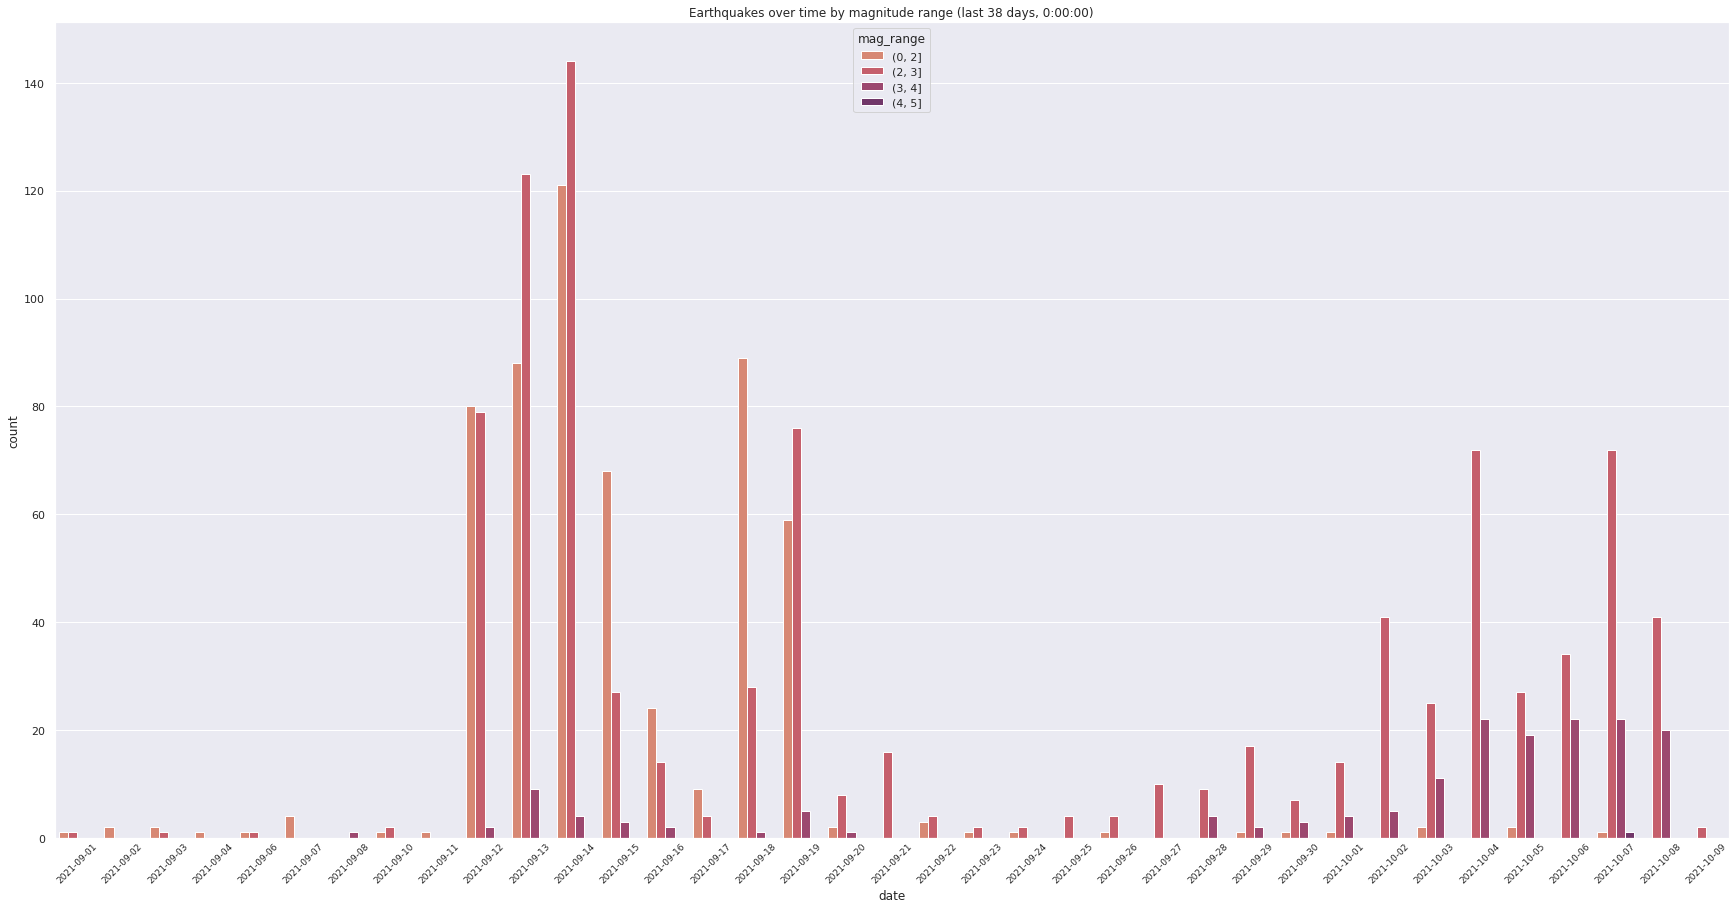

In [4]:
df = master_df[master_df["time"] >= dt(2021, 9, 1)]

fig, ax = plt.subplots()
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")

ax.set_title(f"Earthquakes over time by magnitude range (last {df.iloc[0].date - df.iloc[-1].date})")
sns.countplot(data=df.sort_values("date"), x="date", palette="flare", hue="mag_range", hue_order=df["mag_range"].sort_values().unique(), dodge=True);

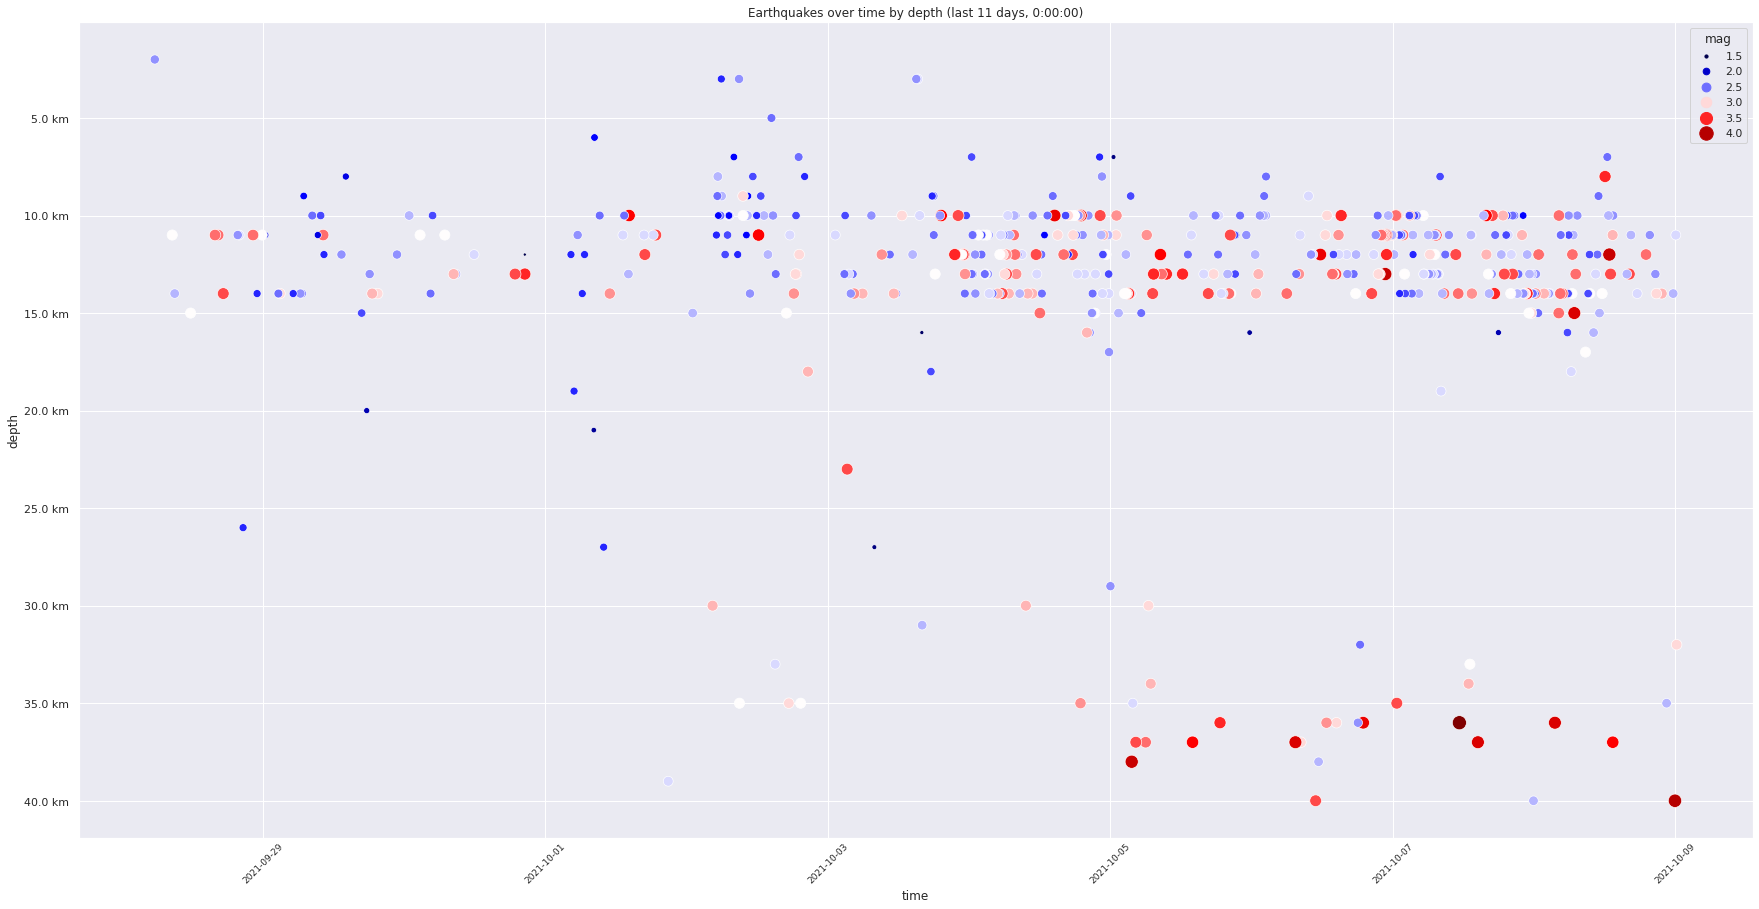

In [5]:
df = master_df[master_df["time"] >= dt(2021, 9, 28)]

fig, ax = plt.subplots()
ax.set_title(f"Earthquakes over time by depth (last {df.iloc[0].date - df.iloc[-1NEW EARTHQUAKE 19m32s ago (2021-10-09 00:03:43.6 +0000 UTC)
ml 2.8  CANARY ISLANDS, SPAIN REGION, DEPTH 11 km
> ml 2.8  CANARY ISLANDS, SPAIN REGION, DEPTH 11 km
ml 2.8  CANARY ISLANDS, SPAIN REGION, DEPTH 11 km
> ml 2.8  CANARY ISLANDS, SPAIN REGION, DEPTH 11 km
https://www.seismicportal.eu/eventdetails.html?unid=20211009_0000002
].date})")
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f km'))
ax.invert_yaxis()


sns.scatterplot(data=df, x="time", y="depth", hue="mag", size="mag", sizes=(10, 200), palette="seismic");

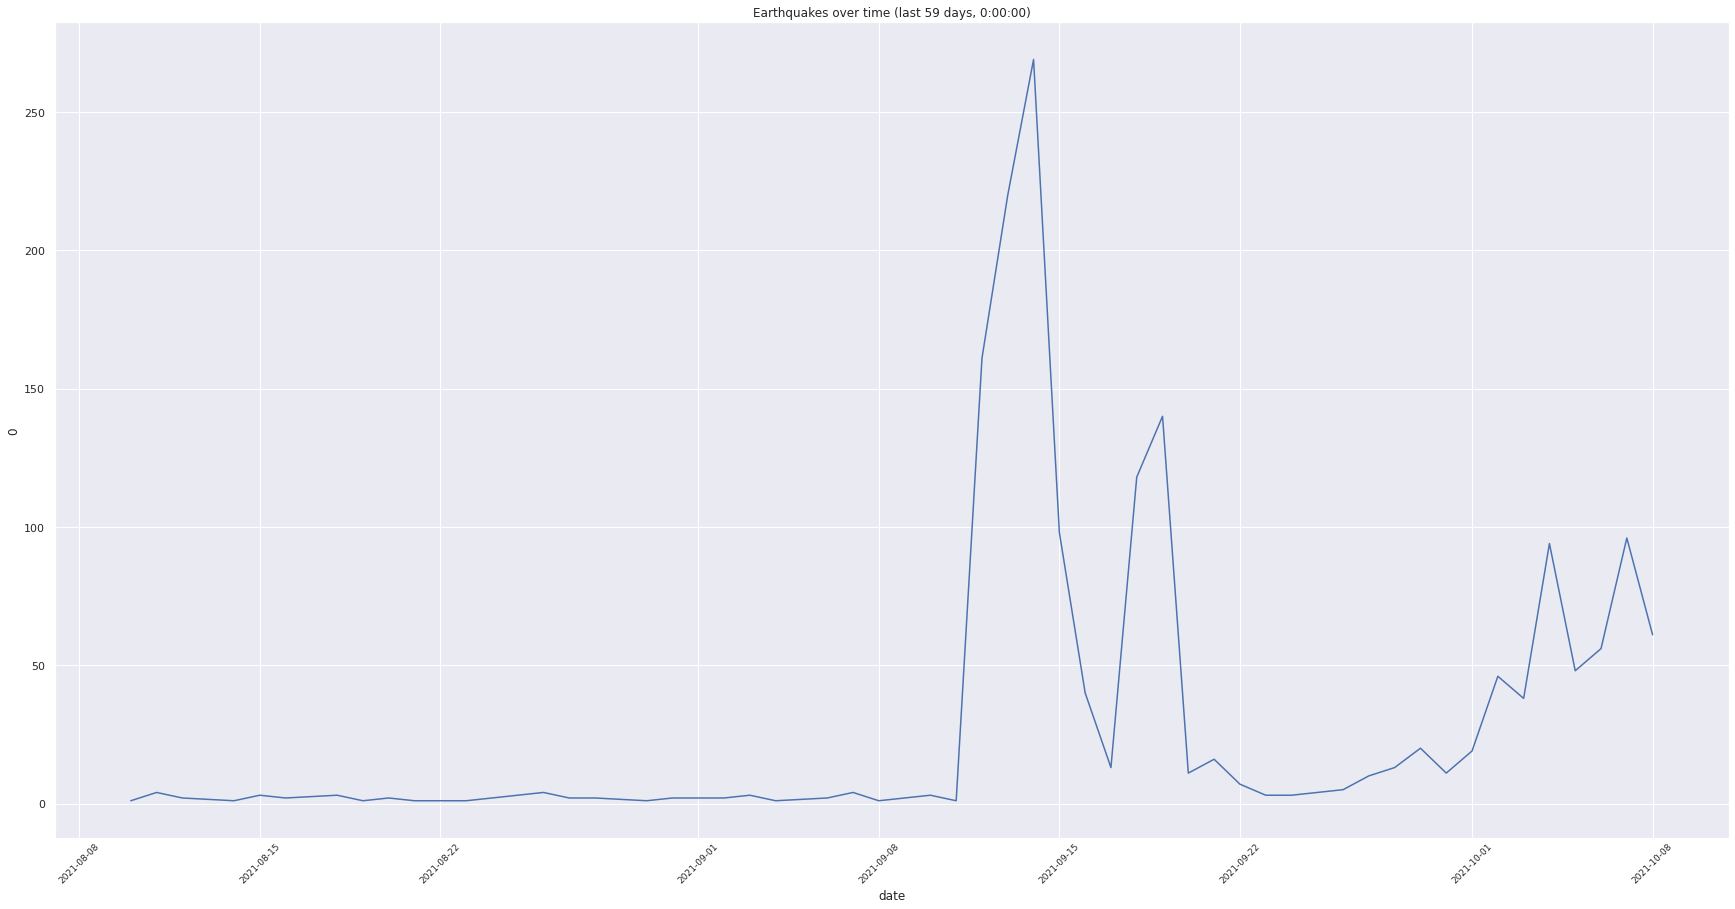

In [6]:
df = master_df[master_df["date"] < master_df.iloc[0].date]

fig, ax = plt.subplots()
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")

ax.set_title(f"Earthquakes over time (last {df.iloc[0].date - df.iloc[-1].date})")

sns.lineplot(data=df.groupby("date").size().reset_index(), x="date", y=df.groupby("date").size().reset_index()[0]);

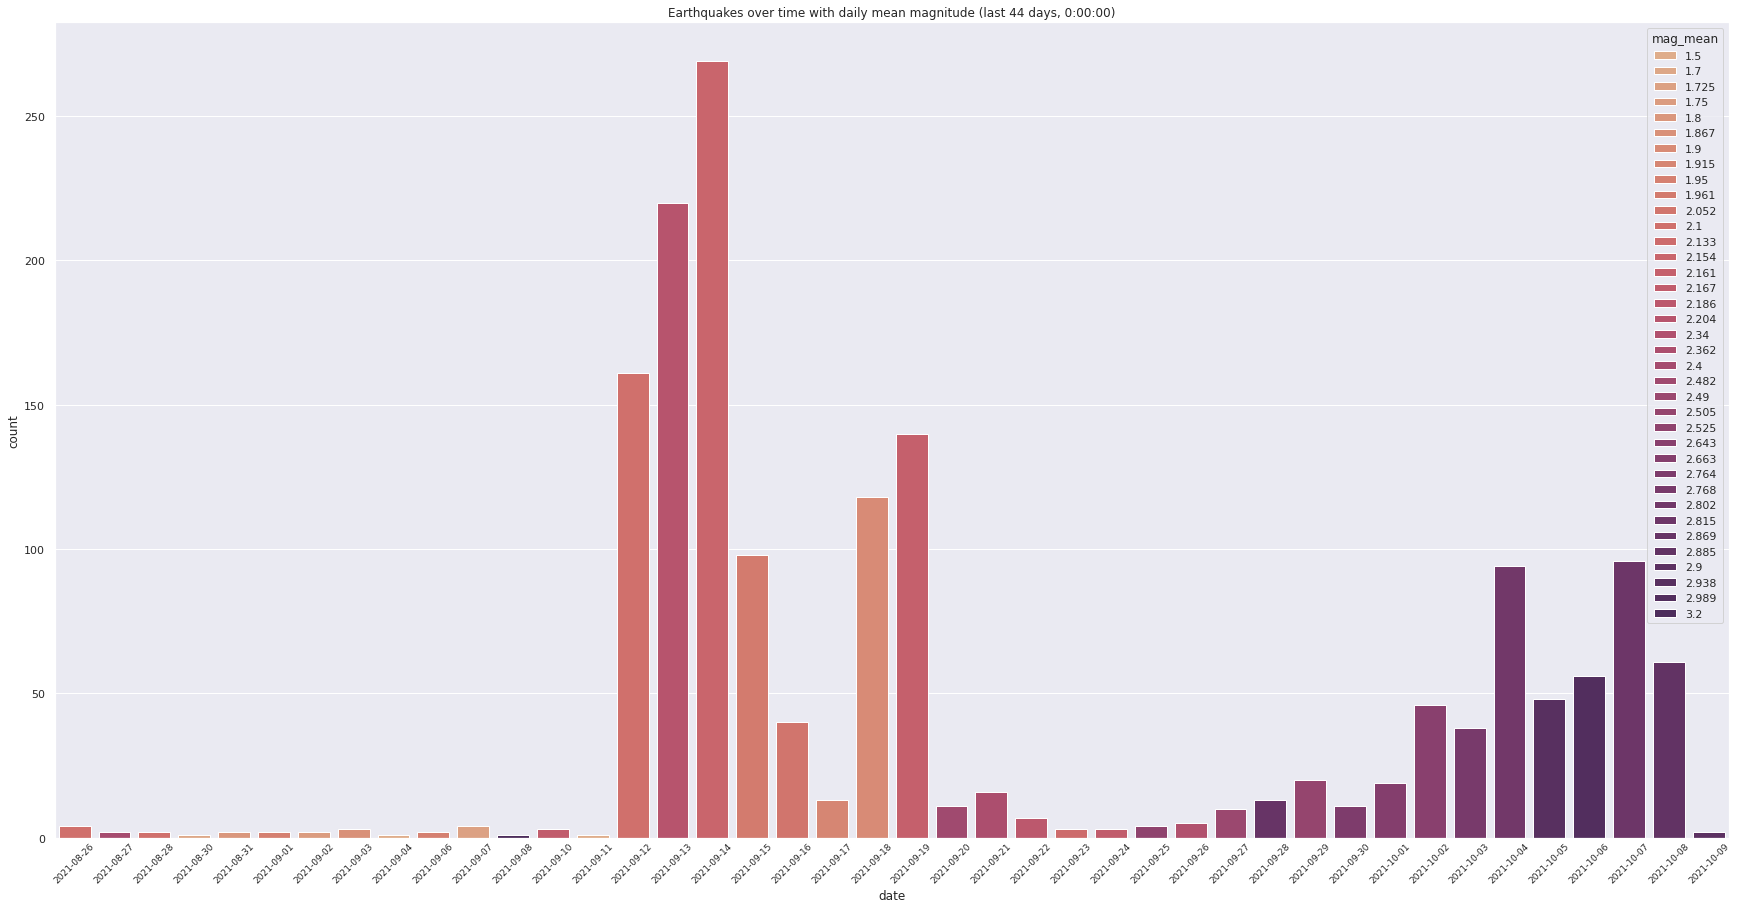

In [7]:
df = master_df[master_df["time"] >= dt.now() - timedelta(days=45)]

fig, ax = plt.subplots()
ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")
ax.set_title(f"Earthquakes over time with daily mean magnitude (last {df.iloc[0].date - df.iloc[-1].date})")

sns.countplot(data=df.sort_values("date"), x="date", palette="flare", hue="mag_mean", dodge=False);

In [8]:
print(f"This notebook was last updated: {dt.utcnow()} UTC")

This notebook was last updated: 2021-10-09 00:25:08.137399 UTC


## Donation

If you find this  useful please consider donating to one of my crypto account. Thank you :)

[![Donate](https://img.shields.io/badge/Donate-BTC-green.svg?style=plastic&logo=bitcoin)](https://raw.githubusercontent.com/Anonymous5726221/lapalma_data/master/Donate/BTC_Bitcoin)
[![Donate](https://img.shields.io/badge/Donate-BNB-green.svg?style=plastic&logo=binance)](https://raw.githubusercontent.com/Anonymous5726221/lapalma_data/master/Donate/BNB_BinanceSmartChain)
[![Donate](https://img.shields.io/badge/Donate-FTM-green.svg?style=plastic&logo=data:image/svg%2bxml;base64,PHN2ZyBjbGlwLXJ1bGU9ImV2ZW5vZGQiIGZpbGwtcnVsZT0iZXZlbm9kZCIgc3Ryb2tlLWxpbmVqb2luPSJyb3VuZCIgc3Ryb2tlLW1pdGVybGltaXQ9IjIiIHZpZXdCb3g9IjAgMCA1NjAgNDAwIiB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciPjxjaXJjbGUgY3g9IjI4MCIgY3k9IjIwMCIgZmlsbD0iIzEzYjVlYyIgcj0iMTUwIiBzdHJva2Utd2lkdGg9IjkuMzc1Ii8+PHBhdGggZD0ibTE3LjIgMTIuOSAzLjYtMi4xdjQuMnptMy42IDktNC44IDIuOC00LjgtMi44di00LjlsNC44IDIuOCA0LjgtMi44em0tOS42LTExLjEgMy42IDIuMS0zLjYgMi4xem01LjQgMy4xIDMuNiAyLjEtMy42IDIuMXptLTEuMiA0LjItMy42LTIuMSAzLjYtMi4xem00LjgtOC4zLTQuMiAyLjQtNC4yLTIuNCA0LjItMi41em0tMTAuMi0uNHYxMy4xbDYgMy40IDYtMy40di0xMy4xbC02LTMuNHoiIGZpbGw9IiNmZmYiIHRyYW5zZm9ybT0ibWF0cml4KDkuMzc1IDAgMCA5LjM3NSAxMzAgNTApIi8+PC9zdmc+)](https://raw.githubusercontent.com/Anonymous5726221/lapalma_data/master/Donate/FTM_Fantom)